# 10 - Policy Optimization

**Phase 4: Autoscaling Logic - Day 12**

Optimize scaling policy parameters to find the best cost-SLA tradeoff:

1. **Grid Search** - Test different threshold combinations
2. **Cooldown Optimization** - Find optimal cooldown periods
3. **Multi-objective Optimization** - Pareto frontier analysis
4. **Final Configuration** - Document optimal parameters

In [1]:
# Standard imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json

# Project imports
from src.scaling.config import ScalingConfig, CONSERVATIVE_CONFIG, AGGRESSIVE_CONFIG, BALANCED_CONFIG
from src.scaling.policy import ScalingPolicy, ScalingAction, ReactivePolicy, PredictivePolicy
from src.scaling.simulator import CostSimulator, SimulationMetrics

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print(f"Project root: {project_root}")

Project root: C:\Users\Admin\OneDrive\Documents\python\datafollow


## 1. Load Data

In [2]:
# Paths
DATA_DIR = project_root / "DATA"
PROCESSED_DIR = DATA_DIR / "processed"
MODELS_DIR = project_root / "models"
MODELS_DIR.mkdir(exist_ok=True)

# Load test data for optimization
df_test = pd.read_parquet(PROCESSED_DIR / "test_features_5m.parquet")
df_train = pd.read_parquet(PROCESSED_DIR / "train_features_5m.parquet")

# Use training data for optimization, test for validation
train_loads = df_train['request_count'].values
train_timestamps = pd.to_datetime(df_train['timestamp'])

test_loads = df_test['request_count'].values
test_timestamps = pd.to_datetime(df_test['timestamp'])

print(f"Train data: {len(train_loads)} periods ({len(train_loads) * 5 / 60 / 24:.1f} days)")
print(f"Test data: {len(test_loads)} periods ({len(test_loads) * 5 / 60 / 24:.1f} days)")
print(f"\nTrain load stats:")
print(f"  Mean: {np.mean(train_loads):.0f} requests/5min")
print(f"  Max: {np.max(train_loads):.0f} requests/5min")
print(f"  Min: {np.min(train_loads):.0f} requests/5min")

Train data: 15264 periods (53.0 days)


Test data: 2592 periods (9.0 days)

Train load stats:
  Mean: 192 requests/5min
  Max: 1500 requests/5min
  Min: 0 requests/5min


## 2. Base Configuration

In [3]:
# Base configuration - will optimize thresholds from here
BASE_CONFIG = ScalingConfig(
    min_servers=1,
    max_servers=50,
    requests_per_server=100,  # Each server handles 100 requests per 5-min
    cost_per_server_per_hour=0.10,  # $0.10 per server per hour
    time_window_minutes=5,
    scale_out_consecutive=3,
    scale_in_consecutive=6,
    cooldown_minutes=5,
    scale_out_increment=2,
    scale_in_decrement=1,
)

# Create simulator
simulator = CostSimulator(BASE_CONFIG)

print("Base Configuration:")
for key, value in BASE_CONFIG.to_dict().items():
    print(f"  {key}: {value}")

Base Configuration:
  min_servers: 1
  max_servers: 50
  requests_per_server: 100
  scale_out_threshold: 0.8
  scale_in_threshold: 0.3
  scale_out_consecutive: 3
  scale_in_consecutive: 6
  cooldown_minutes: 5
  scale_out_increment: 2
  scale_in_decrement: 1
  cost_per_server_per_hour: 0.1
  time_window_minutes: 5


## 3. Grid Search: Threshold Optimization

In [4]:
# Define search ranges
scale_out_range = [0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
scale_in_range = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40]

print(f"Grid search parameters:")
print(f"  Scale Out Thresholds: {scale_out_range}")
print(f"  Scale In Thresholds: {scale_in_range}")
print(f"  Total combinations: {len(scale_out_range) * len(scale_in_range)}")

# Run grid search on training data
grid_results = simulator.grid_search_thresholds(
    loads=train_loads,
    scale_out_range=scale_out_range,
    scale_in_range=scale_in_range,
    timestamps=train_timestamps.tolist()
)

print(f"\nCompleted {len(grid_results)} valid combinations")
grid_results.head(10)

Grid search parameters:
  Scale Out Thresholds: [0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
  Scale In Thresholds: [0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
  Total combinations: 36



Completed 36 valid combinations


,scale_out_threshold,scale_in_threshold,total_cost,avg_utilization,sla_violations,sla_violation_rate,scaling_events,avg_servers
0,0.65,0.15,777.433333,0.297268,11,0.000721,173,6.111897
1,0.65,0.20,727.883333,0.313567,13,0.000852,274,5.722353
2,0.65,0.25,675.808333,0.336151,18,0.001179,335,5.312959
3,0.65,0.30,636.025000,0.355347,22,0.001441,396,5.000197
4,0.65,0.35,599.383333,0.378054,31,0.002031,460,4.712133
5,0.65,0.40,560.991667,0.404697,48,0.003145,568,4.410312
6,0.70,0.15,737.108333,0.313342,15,0.000983,146,5.794877
7,0.70,0.20,680.750000,0.334535,17,0.001114,223,5.351808
8,0.70,0.25,639.975000,0.354050,22,0.001441,290,5.031250
9,0.70,0.30,603.791667,0.376074,39,0.002555,345,4.746790


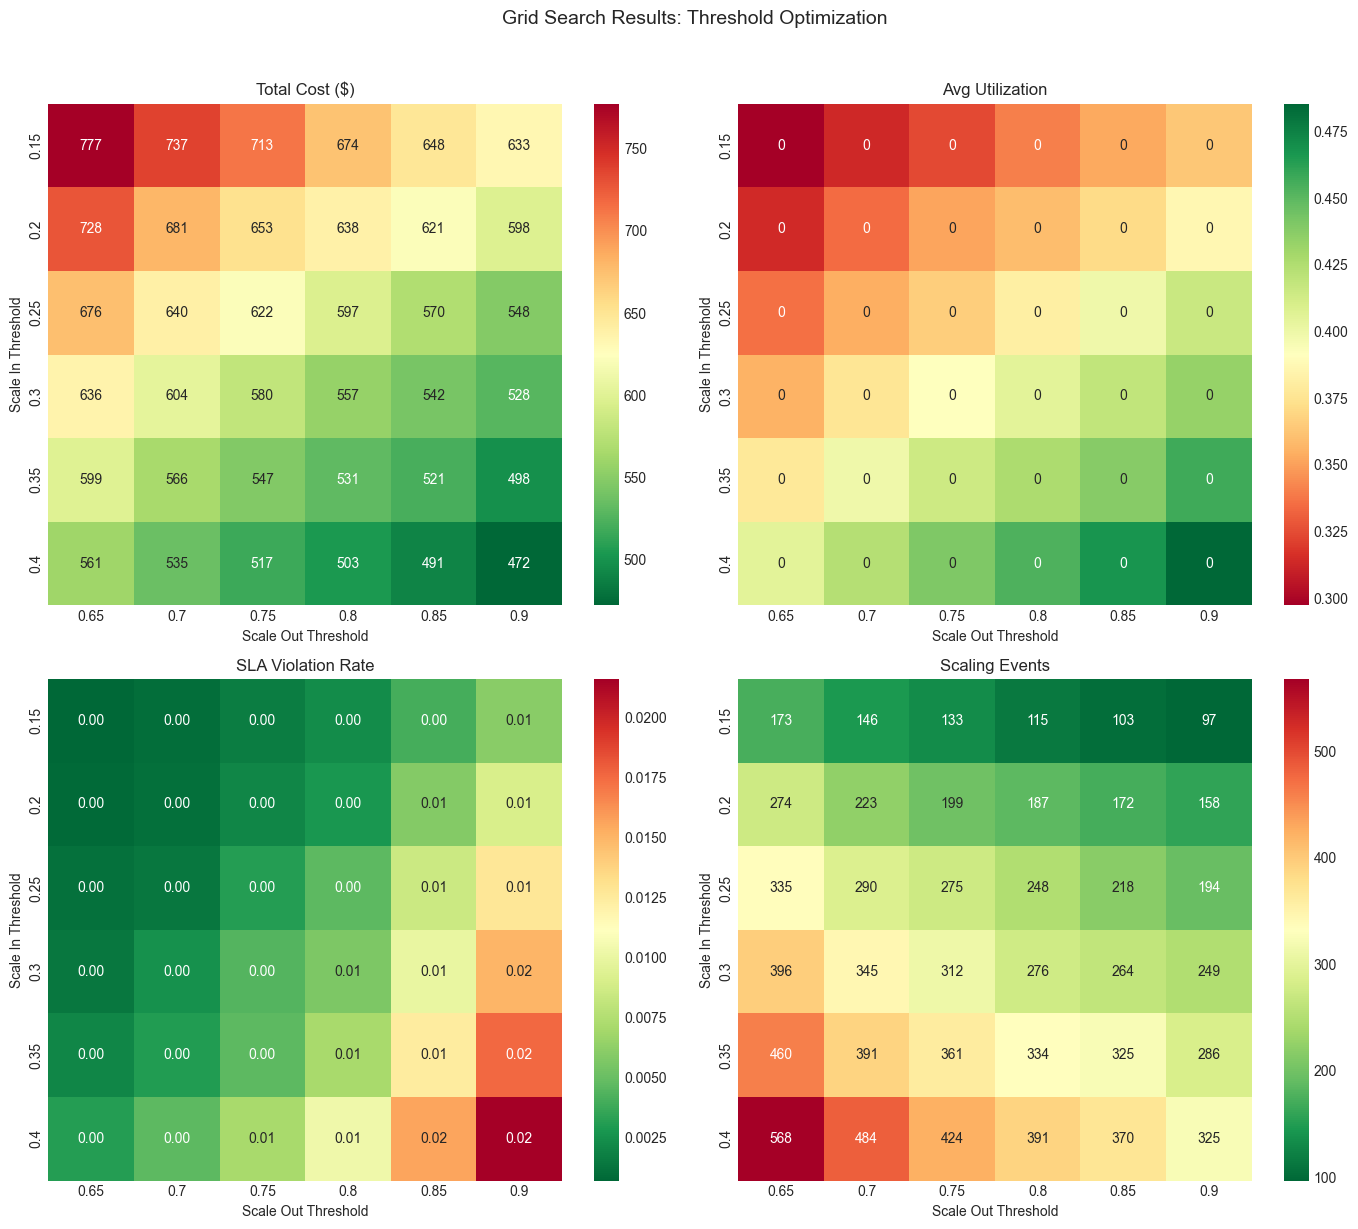

In [5]:
# Visualize grid search results as heatmaps
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

metrics_to_plot = [
    ('total_cost', 'Total Cost ($)', 'RdYlGn_r'),
    ('avg_utilization', 'Avg Utilization', 'RdYlGn'),
    ('sla_violation_rate', 'SLA Violation Rate', 'RdYlGn_r'),
    ('scaling_events', 'Scaling Events', 'RdYlGn_r'),
]

for ax, (metric, title, cmap) in zip(axes.flat, metrics_to_plot):
    # Pivot for heatmap
    pivot = grid_results.pivot(
        index='scale_in_threshold',
        columns='scale_out_threshold',
        values=metric
    )
    
    sns.heatmap(pivot, ax=ax, cmap=cmap, annot=True, fmt='.2f' if 'rate' in metric else '.0f')
    ax.set_title(title)
    ax.set_xlabel('Scale Out Threshold')
    ax.set_ylabel('Scale In Threshold')

plt.suptitle('Grid Search Results: Threshold Optimization', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'grid_search_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
# Find best configurations
print("Best Configurations by Different Criteria:")
print("=" * 70)

# Lowest cost
best_cost = grid_results.loc[grid_results['total_cost'].idxmin()]
print(f"\n1. Lowest Cost:")
print(f"   Scale Out: {best_cost['scale_out_threshold']}, Scale In: {best_cost['scale_in_threshold']}")
print(f"   Cost: ${best_cost['total_cost']:.2f}, SLA Violations: {best_cost['sla_violation_rate']:.2%}")

# Best SLA
best_sla = grid_results.loc[grid_results['sla_violation_rate'].idxmin()]
print(f"\n2. Best SLA Compliance:")
print(f"   Scale Out: {best_sla['scale_out_threshold']}, Scale In: {best_sla['scale_in_threshold']}")
print(f"   Cost: ${best_sla['total_cost']:.2f}, SLA Violations: {best_sla['sla_violation_rate']:.2%}")

# Best balanced (lowest cost with SLA < 5%)
valid_sla = grid_results[grid_results['sla_violation_rate'] < 0.05]
if len(valid_sla) > 0:
    best_balanced = valid_sla.loc[valid_sla['total_cost'].idxmin()]
    print(f"\n3. Best Balanced (SLA < 5%):")
    print(f"   Scale Out: {best_balanced['scale_out_threshold']}, Scale In: {best_balanced['scale_in_threshold']}")
    print(f"   Cost: ${best_balanced['total_cost']:.2f}, SLA Violations: {best_balanced['sla_violation_rate']:.2%}")
else:
    print("\n3. No configuration meets SLA < 5% - adjusting parameters needed")

# Best strict SLA (lowest cost with SLA < 1%)
strict_sla = grid_results[grid_results['sla_violation_rate'] < 0.01]
if len(strict_sla) > 0:
    best_strict = strict_sla.loc[strict_sla['total_cost'].idxmin()]
    print(f"\n4. Best Strict SLA (SLA < 1%):")
    print(f"   Scale Out: {best_strict['scale_out_threshold']}, Scale In: {best_strict['scale_in_threshold']}")
    print(f"   Cost: ${best_strict['total_cost']:.2f}, SLA Violations: {best_strict['sla_violation_rate']:.2%}")

Best Configurations by Different Criteria:

1. Lowest Cost:
   Scale Out: 0.9, Scale In: 0.4
   Cost: $472.04, SLA Violations: 2.16%

2. Best SLA Compliance:
   Scale Out: 0.65, Scale In: 0.15
   Cost: $777.43, SLA Violations: 0.07%

3. Best Balanced (SLA < 5%):
   Scale Out: 0.9, Scale In: 0.4
   Cost: $472.04, SLA Violations: 2.16%

4. Best Strict SLA (SLA < 1%):
   Scale Out: 0.75, Scale In: 0.4
   Cost: $516.77, SLA Violations: 0.71%


## 4. Cooldown Period Optimization

In [7]:
# Test different cooldown periods
cooldown_values = [1, 3, 5, 7, 10, 15]
cooldown_results = []

# Use the best balanced thresholds from grid search
if len(valid_sla) > 0:
    base_out = best_balanced['scale_out_threshold']
    base_in = best_balanced['scale_in_threshold']
else:
    base_out = 0.75
    base_in = 0.25

print(f"Testing cooldown periods with thresholds: out={base_out}, in={base_in}")

for cooldown in cooldown_values:
    config = ScalingConfig(
        min_servers=BASE_CONFIG.min_servers,
        max_servers=BASE_CONFIG.max_servers,
        requests_per_server=BASE_CONFIG.requests_per_server,
        cost_per_server_per_hour=BASE_CONFIG.cost_per_server_per_hour,
        scale_out_threshold=base_out,
        scale_in_threshold=base_in,
        cooldown_minutes=cooldown,
        scale_out_consecutive=3,
        scale_in_consecutive=6,
    )
    
    policy = ScalingPolicy(config)
    metrics = simulator.simulate(train_loads, policy, train_timestamps.tolist())
    
    cooldown_results.append({
        'cooldown_minutes': cooldown,
        'total_cost': metrics.total_cost,
        'avg_utilization': metrics.avg_utilization,
        'sla_violation_rate': metrics.sla_violation_rate,
        'scaling_events': metrics.scaling_events,
        'avg_servers': metrics.avg_servers,
    })

cooldown_df = pd.DataFrame(cooldown_results)
print("\nCooldown Optimization Results:")
cooldown_df

Testing cooldown periods with thresholds: out=0.9, in=0.4



Cooldown Optimization Results:


,cooldown_minutes,total_cost,avg_utilization,sla_violation_rate,scaling_events,avg_servers
0,1,472.041667,0.485373,0.021619,325,3.711019
1,3,472.041667,0.485373,0.021619,325,3.711019
2,5,472.041667,0.485373,0.021619,325,3.711019
3,7,473.750000,0.483761,0.021619,325,3.724450
4,10,473.750000,0.483761,0.021619,325,3.724450
5,15,474.883333,0.482330,0.022013,322,3.733360


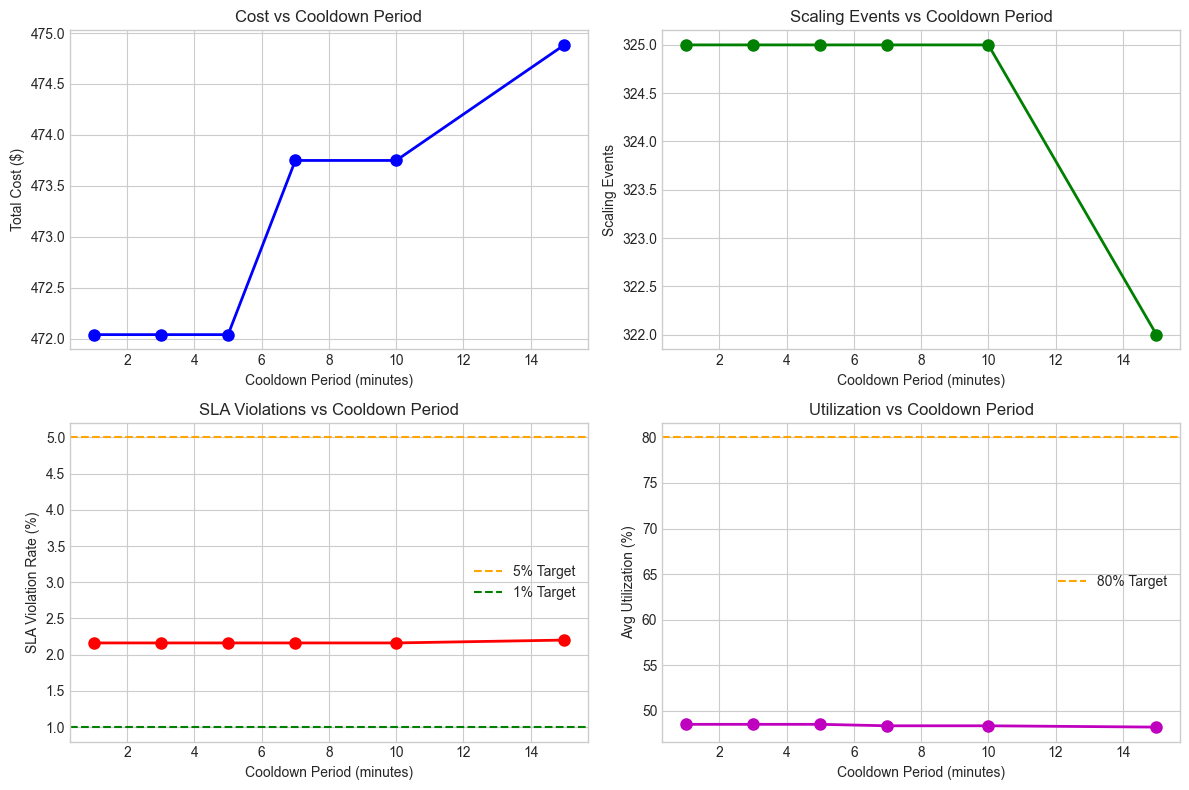

In [8]:
# Visualize cooldown impact
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Cost vs Cooldown
ax = axes[0, 0]
ax.plot(cooldown_df['cooldown_minutes'], cooldown_df['total_cost'], 'bo-', linewidth=2, markersize=8)
ax.set_xlabel('Cooldown Period (minutes)')
ax.set_ylabel('Total Cost ($)')
ax.set_title('Cost vs Cooldown Period')

# Scaling Events vs Cooldown
ax = axes[0, 1]
ax.plot(cooldown_df['cooldown_minutes'], cooldown_df['scaling_events'], 'go-', linewidth=2, markersize=8)
ax.set_xlabel('Cooldown Period (minutes)')
ax.set_ylabel('Scaling Events')
ax.set_title('Scaling Events vs Cooldown Period')

# SLA Violations vs Cooldown
ax = axes[1, 0]
ax.plot(cooldown_df['cooldown_minutes'], cooldown_df['sla_violation_rate'] * 100, 'ro-', linewidth=2, markersize=8)
ax.axhline(5, color='orange', linestyle='--', label='5% Target')
ax.axhline(1, color='green', linestyle='--', label='1% Target')
ax.set_xlabel('Cooldown Period (minutes)')
ax.set_ylabel('SLA Violation Rate (%)')
ax.set_title('SLA Violations vs Cooldown Period')
ax.legend()

# Avg Utilization vs Cooldown
ax = axes[1, 1]
ax.plot(cooldown_df['cooldown_minutes'], cooldown_df['avg_utilization'] * 100, 'mo-', linewidth=2, markersize=8)
ax.axhline(80, color='orange', linestyle='--', label='80% Target')
ax.set_xlabel('Cooldown Period (minutes)')
ax.set_ylabel('Avg Utilization (%)')
ax.set_title('Utilization vs Cooldown Period')
ax.legend()

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'cooldown_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Find optimal cooldown
valid_cooldown = cooldown_df[cooldown_df['sla_violation_rate'] < 0.05]
if len(valid_cooldown) > 0:
    best_cooldown = valid_cooldown.loc[valid_cooldown['total_cost'].idxmin()]
    print(f"Optimal Cooldown: {best_cooldown['cooldown_minutes']} minutes")
    print(f"  Cost: ${best_cooldown['total_cost']:.2f}")
    print(f"  SLA Violations: {best_cooldown['sla_violation_rate']:.2%}")
    print(f"  Scaling Events: {best_cooldown['scaling_events']:.0f}")
else:
    best_cooldown = cooldown_df.loc[cooldown_df['sla_violation_rate'].idxmin()]
    print(f"Best available (no SLA < 5%): {best_cooldown['cooldown_minutes']} minutes")

Optimal Cooldown: 1.0 minutes
  Cost: $472.04
  SLA Violations: 2.16%
  Scaling Events: 325


## 5. Consecutive Periods Optimization

In [10]:
# Test different consecutive period requirements
consecutive_values = [(1, 2), (2, 4), (3, 6), (4, 8), (5, 10)]
consecutive_results = []

optimal_cooldown = int(best_cooldown['cooldown_minutes']) if 'best_cooldown' in dir() else 5

for scale_out_consec, scale_in_consec in consecutive_values:
    config = ScalingConfig(
        min_servers=BASE_CONFIG.min_servers,
        max_servers=BASE_CONFIG.max_servers,
        requests_per_server=BASE_CONFIG.requests_per_server,
        cost_per_server_per_hour=BASE_CONFIG.cost_per_server_per_hour,
        scale_out_threshold=base_out,
        scale_in_threshold=base_in,
        cooldown_minutes=optimal_cooldown,
        scale_out_consecutive=scale_out_consec,
        scale_in_consecutive=scale_in_consec,
    )
    
    policy = ScalingPolicy(config)
    metrics = simulator.simulate(train_loads, policy, train_timestamps.tolist())
    
    consecutive_results.append({
        'scale_out_consecutive': scale_out_consec,
        'scale_in_consecutive': scale_in_consec,
        'total_cost': metrics.total_cost,
        'sla_violation_rate': metrics.sla_violation_rate,
        'scaling_events': metrics.scaling_events,
    })

consecutive_df = pd.DataFrame(consecutive_results)
print("Consecutive Periods Optimization Results:")
consecutive_df

Consecutive Periods Optimization Results:


,scale_out_consecutive,scale_in_consecutive,total_cost,sla_violation_rate,scaling_events
0,1,2,468.500000,0.000066,1361
1,2,4,468.900000,0.011661,469
2,3,6,472.041667,0.021619,325
3,4,8,478.058333,0.028957,283
4,5,10,476.166667,0.038325,246


## 6. Pareto Frontier Analysis

In [11]:
# Create comprehensive search combining all parameters
comprehensive_results = []

for scale_out in [0.70, 0.75, 0.80, 0.85]:
    for scale_in in [0.20, 0.25, 0.30, 0.35]:
        if scale_in >= scale_out:
            continue
        for cooldown in [3, 5, 10]:
            config = ScalingConfig(
                min_servers=BASE_CONFIG.min_servers,
                max_servers=BASE_CONFIG.max_servers,
                requests_per_server=BASE_CONFIG.requests_per_server,
                cost_per_server_per_hour=BASE_CONFIG.cost_per_server_per_hour,
                scale_out_threshold=scale_out,
                scale_in_threshold=scale_in,
                cooldown_minutes=cooldown,
            )
            
            policy = ScalingPolicy(config)
            metrics = simulator.simulate(train_loads, policy, train_timestamps.tolist())
            
            comprehensive_results.append({
                'scale_out': scale_out,
                'scale_in': scale_in,
                'cooldown': cooldown,
                'total_cost': metrics.total_cost,
                'sla_violation_rate': metrics.sla_violation_rate,
                'avg_utilization': metrics.avg_utilization,
                'scaling_events': metrics.scaling_events,
            })

comp_df = pd.DataFrame(comprehensive_results)
print(f"Tested {len(comp_df)} configurations")

Tested 48 configurations


In [12]:
# Identify Pareto-optimal configurations
def is_pareto_optimal(row, df, cost_col='total_cost', sla_col='sla_violation_rate'):
    """Check if a configuration is Pareto-optimal (not dominated)."""
    for _, other in df.iterrows():
        if (other[cost_col] <= row[cost_col] and 
            other[sla_col] < row[sla_col]):
            return False
        if (other[cost_col] < row[cost_col] and 
            other[sla_col] <= row[sla_col]):
            return False
    return True

comp_df['pareto_optimal'] = comp_df.apply(lambda row: is_pareto_optimal(row, comp_df), axis=1)
pareto_configs = comp_df[comp_df['pareto_optimal']]

print(f"Pareto-optimal configurations: {len(pareto_configs)} out of {len(comp_df)}")
pareto_configs.sort_values('total_cost')

Pareto-optimal configurations: 14 out of 48


,scale_out,scale_in,cooldown,total_cost,sla_violation_rate,avg_utilization,scaling_events,pareto_optimal
45,0.85,0.35,3,521.083333,0.012448,0.437907,325,True
46,0.85,0.35,5,521.083333,0.012448,0.437907,325,True
33,0.80,0.35,3,531.208333,0.007141,0.426193,334,True
34,0.80,0.35,5,531.208333,0.007141,0.426193,334,True
22,0.75,0.35,5,546.575000,0.004717,0.414156,361,True
21,0.75,0.35,3,546.575000,0.004717,0.414156,361,True
9,0.70,0.35,3,565.975000,0.003079,0.398898,391,True
10,0.70,0.35,5,565.975000,0.003079,0.398898,391,True
7,0.70,0.30,5,603.791667,0.002555,0.376074,345,True
6,0.70,0.30,3,603.791667,0.002555,0.376074,345,True


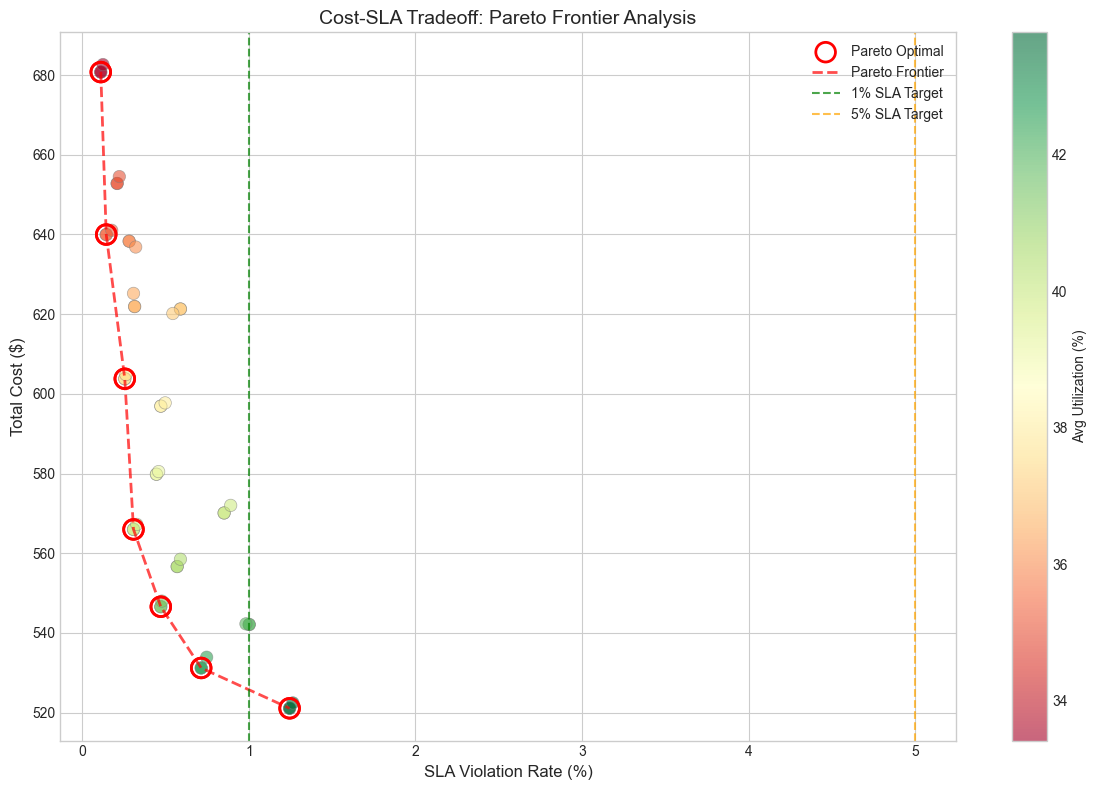

In [13]:
# Visualize Pareto frontier
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all configurations
scatter = ax.scatter(
    comp_df['sla_violation_rate'] * 100,
    comp_df['total_cost'],
    c=comp_df['avg_utilization'] * 100,
    cmap='RdYlGn',
    s=80,
    alpha=0.6,
    edgecolors='gray',
    linewidth=0.5,
)

# Highlight Pareto-optimal
ax.scatter(
    pareto_configs['sla_violation_rate'] * 100,
    pareto_configs['total_cost'],
    s=200,
    facecolors='none',
    edgecolors='red',
    linewidth=2,
    label='Pareto Optimal',
)

# Draw Pareto frontier line
pareto_sorted = pareto_configs.sort_values('sla_violation_rate')
ax.plot(
    pareto_sorted['sla_violation_rate'] * 100,
    pareto_sorted['total_cost'],
    'r--',
    linewidth=2,
    alpha=0.7,
    label='Pareto Frontier',
)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Avg Utilization (%)')

# Add SLA target lines
ax.axvline(1, color='green', linestyle='--', alpha=0.7, label='1% SLA Target')
ax.axvline(5, color='orange', linestyle='--', alpha=0.7, label='5% SLA Target')

ax.set_xlabel('SLA Violation Rate (%)', fontsize=12)
ax.set_ylabel('Total Cost ($)', fontsize=12)
ax.set_title('Cost-SLA Tradeoff: Pareto Frontier Analysis', fontsize=14)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'pareto_frontier.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Validate Optimal Configuration on Test Data

In [14]:
# Select optimal configuration (lowest cost with SLA < 5%)
optimal_config, optimal_metrics = simulator.optimize_for_cost(
    loads=train_loads,
    max_sla_violation_rate=0.05,
    timestamps=train_timestamps.tolist()
)

print("Optimal Configuration (from training data):")
print("=" * 50)
for key, value in optimal_config.to_dict().items():
    print(f"  {key}: {value}")

print(f"\nTraining Performance:")
print(optimal_metrics)

Optimal Configuration (from training data):
  min_servers: 1
  max_servers: 50
  requests_per_server: 100
  scale_out_threshold: 0.85
  scale_in_threshold: 0.35
  scale_out_consecutive: 3
  scale_in_consecutive: 6
  cooldown_minutes: 5
  scale_out_increment: 2
  scale_in_decrement: 1
  cost_per_server_per_hour: 0.1
  time_window_minutes: 5

Training Performance:
Simulation Results:
  Total Cost: $521.08
  Avg Cost/Hour: $0.4097
  Avg Servers: 4.10
  Avg Utilization: 43.8%
  SLA Violations: 190 (1.2%)
  Scaling Events: 325 (out: 109, in: 216)


In [15]:
# Validate on test data
test_simulator = CostSimulator(optimal_config)
test_policy = ScalingPolicy(optimal_config)
test_metrics = test_simulator.simulate(
    loads=test_loads,
    policy=test_policy,
    timestamps=test_timestamps.tolist()
)

print("\nTest Data Validation:")
print("=" * 50)
print(test_metrics)

# Compare training vs test
print("\n" + "=" * 50)
print("Training vs Test Comparison:")
print(f"  Cost: ${optimal_metrics.total_cost:.2f} (train) vs ${test_metrics.total_cost:.2f} (test)")
print(f"  SLA Violations: {optimal_metrics.sla_violation_rate:.2%} (train) vs {test_metrics.sla_violation_rate:.2%} (test)")
print(f"  Avg Utilization: {optimal_metrics.avg_utilization:.1%} (train) vs {test_metrics.avg_utilization:.1%} (test)")


Test Data Validation:
Simulation Results:
  Total Cost: $88.22
  Avg Cost/Hour: $0.4084
  Avg Servers: 4.08
  Avg Utilization: 50.0%
  SLA Violations: 31 (1.2%)
  Scaling Events: 55 (out: 20, in: 35)

Training vs Test Comparison:
  Cost: $521.08 (train) vs $88.22 (test)
  SLA Violations: 1.24% (train) vs 1.20% (test)
  Avg Utilization: 43.8% (train) vs 50.0% (test)


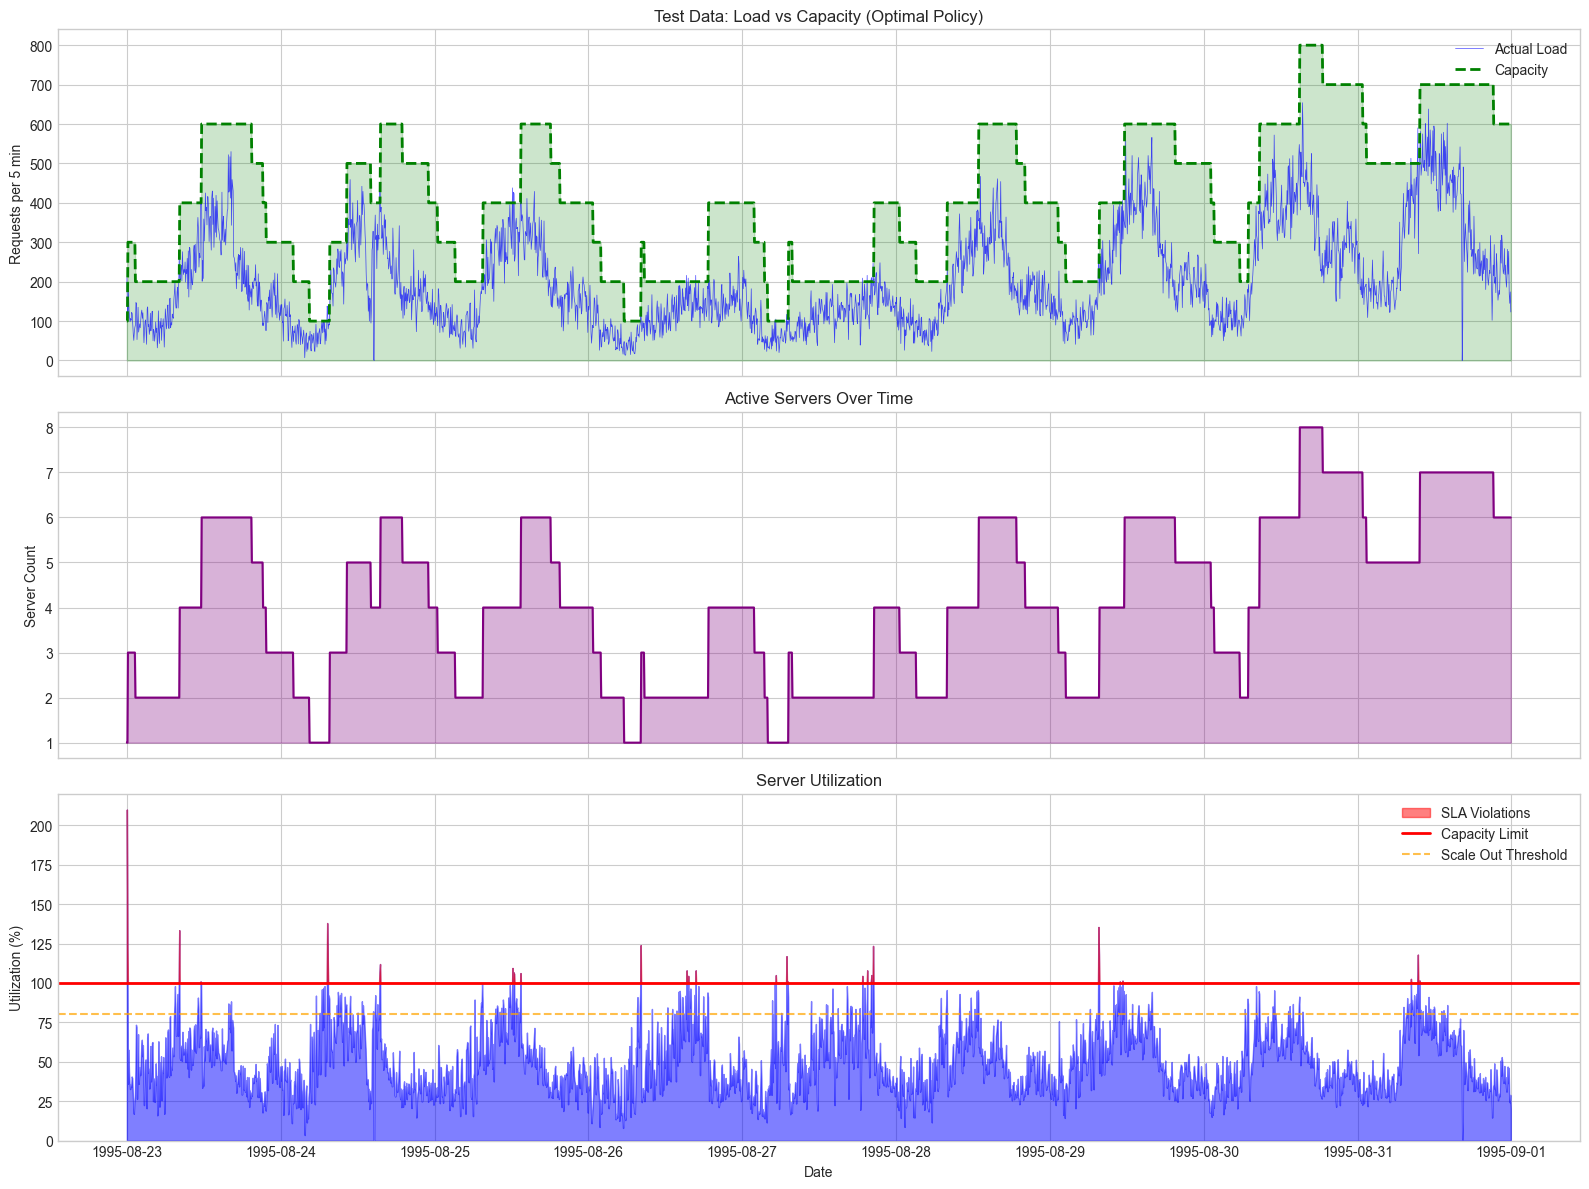

In [16]:
# Visualize test performance
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Load and capacity
ax = axes[0]
ax.plot(test_timestamps, test_loads, label='Actual Load', color='blue', alpha=0.7, linewidth=0.5)
capacity = np.array(test_metrics.servers_over_time) * optimal_config.requests_per_server
ax.plot(test_timestamps, capacity, label='Capacity', color='green', linestyle='--', linewidth=2)
ax.fill_between(test_timestamps, 0, capacity, alpha=0.2, color='green')
ax.set_ylabel('Requests per 5 min')
ax.set_title('Test Data: Load vs Capacity (Optimal Policy)')
ax.legend()

# Server count
ax = axes[1]
ax.plot(test_timestamps, test_metrics.servers_over_time, color='purple', linewidth=1.5)
ax.fill_between(test_timestamps, optimal_config.min_servers, test_metrics.servers_over_time, 
                alpha=0.3, color='purple')
ax.set_ylabel('Server Count')
ax.set_title('Active Servers Over Time')

# Utilization with SLA violations highlighted
ax = axes[2]
utilization = np.array(test_metrics.utilization_over_time)
ax.fill_between(test_timestamps, 0, utilization * 100, alpha=0.5, color='blue')
ax.fill_between(test_timestamps, 100, np.where(utilization > 1, utilization * 100, 100), 
                alpha=0.5, color='red', label='SLA Violations')
ax.axhline(100, color='red', linestyle='-', linewidth=2, label='Capacity Limit')
ax.axhline(80, color='orange', linestyle='--', alpha=0.7, label='Scale Out Threshold')
ax.set_ylabel('Utilization (%)')
ax.set_xlabel('Date')
ax.set_title('Server Utilization')
ax.legend()
ax.set_ylim(0, max(150, utilization.max() * 100 + 10))

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'optimal_policy_test.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Final Configuration & Export

In [17]:
# Create final production configuration
PRODUCTION_CONFIG = ScalingConfig(
    min_servers=optimal_config.min_servers,
    max_servers=optimal_config.max_servers,
    requests_per_server=optimal_config.requests_per_server,
    scale_out_threshold=optimal_config.scale_out_threshold,
    scale_in_threshold=optimal_config.scale_in_threshold,
    scale_out_consecutive=optimal_config.scale_out_consecutive,
    scale_in_consecutive=optimal_config.scale_in_consecutive,
    cooldown_minutes=optimal_config.cooldown_minutes,
    scale_out_increment=optimal_config.scale_out_increment,
    scale_in_decrement=optimal_config.scale_in_decrement,
    cost_per_server_per_hour=optimal_config.cost_per_server_per_hour,
    time_window_minutes=optimal_config.time_window_minutes,
)

print("Production Configuration:")
print("=" * 50)
for key, value in PRODUCTION_CONFIG.to_dict().items():
    print(f"  {key}: {value}")

Production Configuration:
  min_servers: 1
  max_servers: 50
  requests_per_server: 100
  scale_out_threshold: 0.85
  scale_in_threshold: 0.35
  scale_out_consecutive: 3
  scale_in_consecutive: 6
  cooldown_minutes: 5
  scale_out_increment: 2
  scale_in_decrement: 1
  cost_per_server_per_hour: 0.1
  time_window_minutes: 5


In [18]:
# Save configuration
config_path = MODELS_DIR / 'optimal_scaling_config.json'
with open(config_path, 'w') as f:
    json.dump(PRODUCTION_CONFIG.to_dict(), f, indent=2)
print(f"Saved optimal configuration to: {config_path}")

# Also save grid search results
grid_results.to_csv(PROCESSED_DIR / 'grid_search_results.csv', index=False)
comp_df.to_csv(PROCESSED_DIR / 'comprehensive_search_results.csv', index=False)
pareto_configs.to_csv(PROCESSED_DIR / 'pareto_optimal_configs.csv', index=False)

print("Saved optimization results:")
print(f"  - Grid search: {PROCESSED_DIR / 'grid_search_results.csv'}")
print(f"  - Comprehensive search: {PROCESSED_DIR / 'comprehensive_search_results.csv'}")
print(f"  - Pareto optimal: {PROCESSED_DIR / 'pareto_optimal_configs.csv'}")

Saved optimal configuration to: C:\Users\Admin\OneDrive\Documents\python\datafollow\models\optimal_scaling_config.json
Saved optimization results:
  - Grid search: C:\Users\Admin\OneDrive\Documents\python\datafollow\DATA\processed\grid_search_results.csv
  - Comprehensive search: C:\Users\Admin\OneDrive\Documents\python\datafollow\DATA\processed\comprehensive_search_results.csv
  - Pareto optimal: C:\Users\Admin\OneDrive\Documents\python\datafollow\DATA\processed\pareto_optimal_configs.csv


## 9. Summary Report

In [19]:
# Calculate cost comparison with baseline
fixed_max_servers = BASE_CONFIG.get_required_servers(np.max(test_loads), target_utilization=0.8)
fixed_metrics = simulator.simulate_fixed(test_loads, fixed_max_servers)

savings = fixed_metrics.total_cost - test_metrics.total_cost
savings_pct = (savings / fixed_metrics.total_cost) * 100

print("=" * 70)
print("POLICY OPTIMIZATION SUMMARY")
print("=" * 70)

print("\n1. OPTIMAL CONFIGURATION")
print(f"   Scale Out Threshold: {PRODUCTION_CONFIG.scale_out_threshold:.0%}")
print(f"   Scale In Threshold: {PRODUCTION_CONFIG.scale_in_threshold:.0%}")
print(f"   Cooldown Period: {PRODUCTION_CONFIG.cooldown_minutes} minutes")
print(f"   Scale Out Consecutive: {PRODUCTION_CONFIG.scale_out_consecutive} periods")
print(f"   Scale In Consecutive: {PRODUCTION_CONFIG.scale_in_consecutive} periods")

print("\n2. TEST PERFORMANCE")
print(f"   Total Cost: ${test_metrics.total_cost:.2f}")
print(f"   Avg Servers: {test_metrics.avg_servers:.2f}")
print(f"   Avg Utilization: {test_metrics.avg_utilization:.1%}")
print(f"   SLA Violations: {test_metrics.sla_violations} ({test_metrics.sla_violation_rate:.2%})")
print(f"   Scaling Events: {test_metrics.scaling_events}")

print("\n3. COST SAVINGS vs FIXED CAPACITY")
print(f"   Fixed Cost ({fixed_max_servers} servers): ${fixed_metrics.total_cost:.2f}")
print(f"   Autoscale Cost: ${test_metrics.total_cost:.2f}")
print(f"   Savings: ${savings:.2f} ({savings_pct:.1f}%)")

print("\n4. PARETO ANALYSIS")
print(f"   Total configurations tested: {len(comp_df)}")
print(f"   Pareto-optimal configurations: {len(pareto_configs)}")

print("\n5. RECOMMENDATIONS")
print("   - Use optimal configuration for balanced cost-SLA tradeoff")
print("   - For stricter SLA, use more conservative thresholds")
print("   - Monitor scaling events to adjust cooldown if flapping occurs")
print("   - Consider predictive scaling for anticipated traffic spikes")

print("\n" + "=" * 70)
print("Phase 4 Autoscaling Logic - COMPLETED")
print("=" * 70)

POLICY OPTIMIZATION SUMMARY

1. OPTIMAL CONFIGURATION
   Scale Out Threshold: 85%
   Scale In Threshold: 35%
   Cooldown Period: 5 minutes
   Scale Out Consecutive: 3 periods
   Scale In Consecutive: 6 periods

2. TEST PERFORMANCE
   Total Cost: $88.22
   Avg Servers: 4.08
   Avg Utilization: 50.0%
   SLA Violations: 31 (1.20%)
   Scaling Events: 55

3. COST SAVINGS vs FIXED CAPACITY
   Fixed Cost (9 servers): $194.40
   Autoscale Cost: $88.22
   Savings: $106.17 (54.6%)

4. PARETO ANALYSIS
   Total configurations tested: 48
   Pareto-optimal configurations: 14

5. RECOMMENDATIONS
   - Use optimal configuration for balanced cost-SLA tradeoff
   - For stricter SLA, use more conservative thresholds
   - Monitor scaling events to adjust cooldown if flapping occurs
   - Consider predictive scaling for anticipated traffic spikes

Phase 4 Autoscaling Logic - COMPLETED


In [20]:
print("\nNotebook completed successfully!")


Notebook completed successfully!
